9. In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [7]:
library(ISLR)
library(ISLR2)
library(ggplot2)
library(caret)
library(boot)
library(leaps)
library(glmnet)
library(pls)
library(dplyr, tidyselect)
College

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
Albertson College,Yes,587,479,158,38,62,678,41,13500,3335,500,675,67,73,9.4,11,9727,55
Albertus Magnus College,Yes,353,340,103,17,45,416,230,13290,5720,500,1500,90,93,11.5,26,8861,63
Albion College,Yes,1899,1720,489,37,68,1594,32,13868,4826,450,850,89,100,13.7,37,11487,73
Albright College,Yes,1038,839,227,30,63,973,306,15595,4400,300,500,79,84,11.3,23,11644,80


In [50]:
set.seed(25)

(a) Split the data set into a training set and a test set.

In [51]:
#https://rpubs.com/lmorgan95/ISLR_CH6_Solutions

train_index <- sample(1:nrow(College), round(nrow(College) * 0.7))
train <- College[train_index, ]
test <- College[-train_index, ]

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

In [52]:
#lets do a best subsets while we're here
best.fit = leaps::regsubsets(Apps ~ ., train)
summary(best.fit)

Subset selection object
Call: regsubsets.formula(Apps ~ ., train)
17 Variables  (and intercept)
            Forced in Forced out
PrivateYes      FALSE      FALSE
Accept          FALSE      FALSE
Enroll          FALSE      FALSE
Top10perc       FALSE      FALSE
Top25perc       FALSE      FALSE
F.Undergrad     FALSE      FALSE
P.Undergrad     FALSE      FALSE
Outstate        FALSE      FALSE
Room.Board      FALSE      FALSE
Books           FALSE      FALSE
Personal        FALSE      FALSE
PhD             FALSE      FALSE
Terminal        FALSE      FALSE
S.F.Ratio       FALSE      FALSE
perc.alumni     FALSE      FALSE
Expend          FALSE      FALSE
Grad.Rate       FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         PrivateYes Accept Enroll Top10perc Top25perc F.Undergrad P.Undergrad
1  ( 1 ) " "        "*"    " "    " "       " "       " "         " "        
2  ( 1 ) " "        "*"    " "    "*"       " "       " "         " "        
3  ( 1 ) " " 

In [57]:
predict.regsubsets = function(object,newdata,id,...){
      form = as.formula(object$call[[2]]) # Extract the formula used when we called regsubsets()
      mat = model.matrix(form,newdata)    # Build the model matrix
      coefi = coef(object,id=id)          # Extract the coefficiants of the ith model
      xvars = names(coefi)                # Pull out the names of the predictors used in the ith model
      mat[,xvars]%*%coefi               # Make predictions using matrix multiplication
}

In [64]:
val_errors = rep(NA,8)

# Iterates over each size i
for(i in 1:8){
    pred = predict.regsubsets(best.fit, test, i)
    val_errors[i] = mean((test$Apps - pred)^2)
}

In [65]:
val_errors

[1] 1837228 1730531 1780350 1855918 1840808 1823996 1831212 1878818

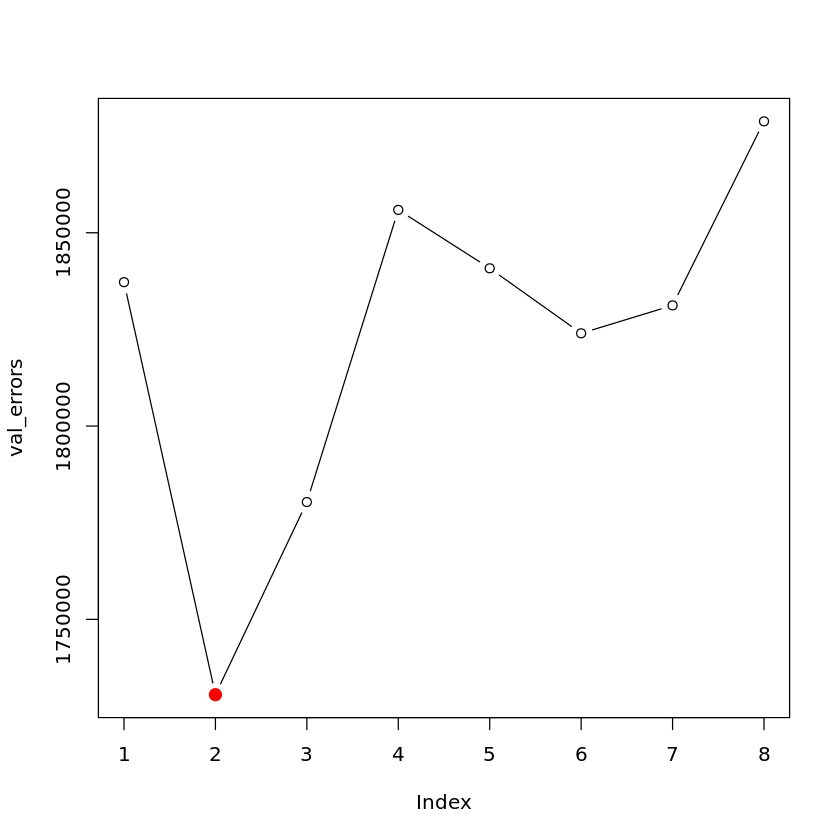

In [67]:
# Find the model with the smallest error
min = which.min(val_errors)

# Plot the errors for each model size
plot(val_errors, type = 'b')
points(min, val_errors[min][1], col = "red", cex = 2, pch = 20)

In [71]:
#coef(best.fit, 5)
ypred = predict.regsubsets(best.fit, test, 2)
mean((ypred -test$Apps)^2)

[1] 1730531

In [132]:
coef(best.fit, 2)

(Intercept)      Accept   Top10perc 
-874.907193    1.360808   40.169923

In [135]:
mean((test$Apps - (-874.907 + test$Accept * 1.360807 + test$Top10perc * 40.169922))^2)

[1] 1730533

(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.

In [72]:
train_mat <- dummyVars(Apps ~ ., data = train, fullRank = F) %>%
  predict(newdata = train) %>%
  as.matrix()

test_mat <- dummyVars(Apps ~ ., data = test, fullRank = F) %>%
  predict(newdata = test) %>%
  as.matrix()

[1] 7.356423

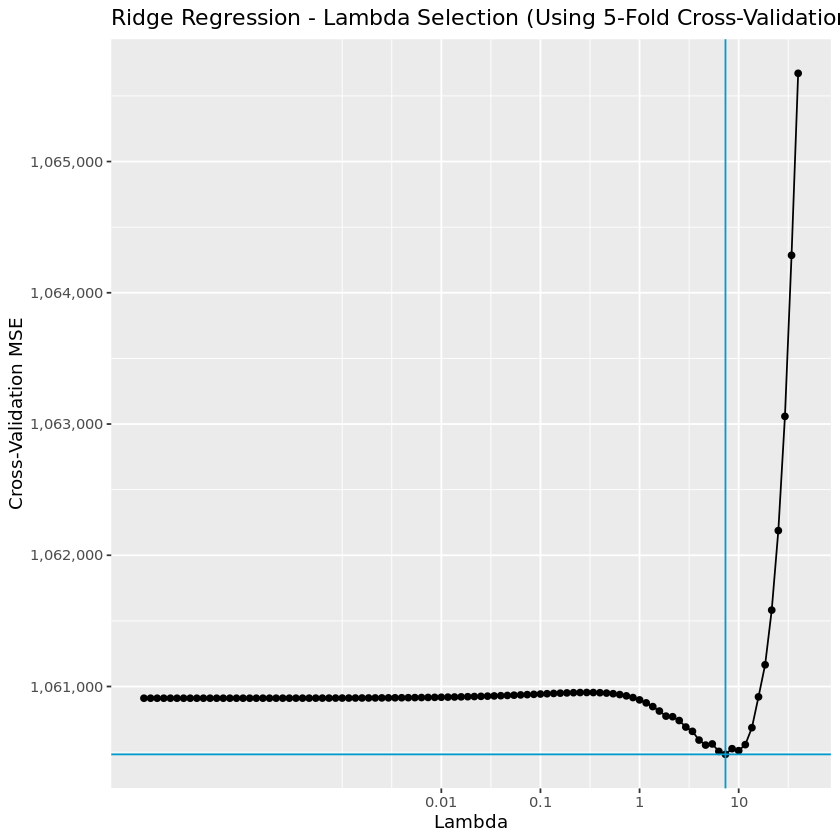

In [73]:
#set.seed(3)

model_ridge <- cv.glmnet(y = train$Apps, 
                         x = train_mat, 
                         alpha = 0, 
                         lambda = 10^seq(1.6,-5, length = 100), 
                         standardize = TRUE, 
                         nfolds = 5)

model_ridge$lambda.min

data.frame(lambda = model_ridge$lambda, 
           cv_mse = model_ridge$cvm) %>%
  ggplot(aes(x = lambda, y = cv_mse)) + 
  geom_point() + 
  geom_line() + 
  geom_vline(xintercept = model_ridge$lambda.min, col = "deepskyblue3") +
  geom_hline(yintercept = min(model_ridge$cvm), col = "deepskyblue3") +
  scale_x_continuous(trans = 'log10', breaks = c(0.01, 0.1, 1, 10, 100), labels = c(0.01, 0.1, 1, 10, 100)) + 
  scale_y_continuous(labels = scales::comma_format()) + 
  theme(legend.position = "bottom") + 
  labs(x = "Lambda", 
       y = "Cross-Validation MSE", 
       col = "Non-Zero Coefficients:", 
       title = "Ridge Regression - Lambda Selection (Using 5-Fold Cross-Validation)")

In [74]:
model_pred_ridge <- glmnet(train_mat, College$Apps[train_index], alpha = 0,
    lambda = model_ridge$lambda.min, thresh = 1e-12)
mean((College$Apps[-train_index] - predict(model_pred_ridge, test_mat))^2)

[1] 1955233

(d) Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

[1] 5.023543

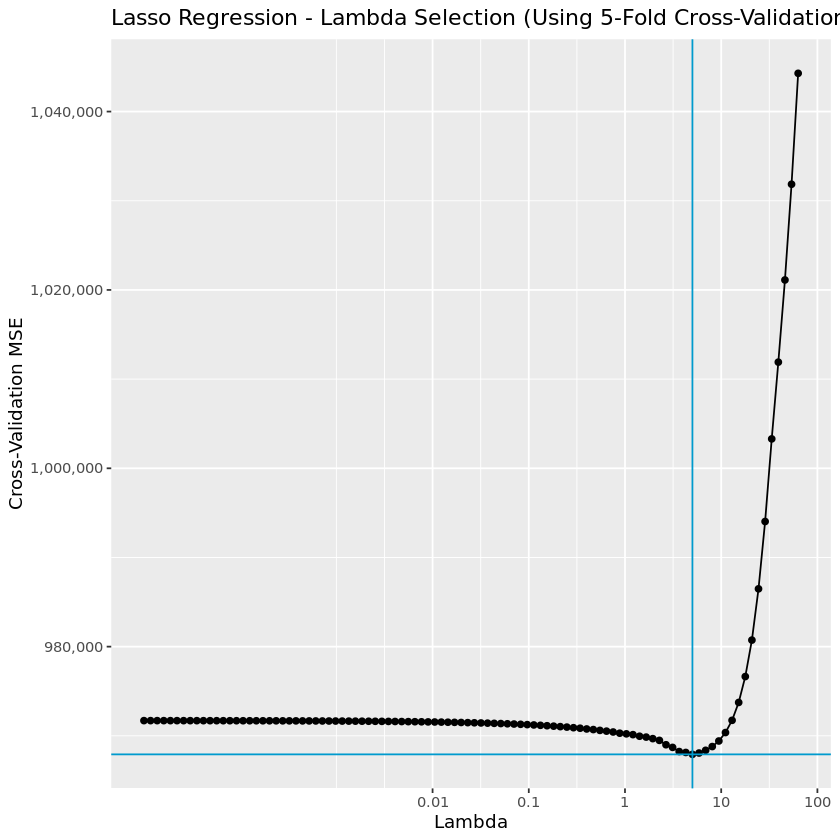

In [75]:
#set.seed(3)

model_lasso <- cv.glmnet(y = train$Apps, 
                         x = train_mat, 
                         alpha = 1, 
                         lambda = 10^seq(1.8,-5, length = 100), 
                         standardize = TRUE, 
                         nfolds = 5)

model_lasso$lambda.min

data.frame(lambda = model_lasso$lambda, 
           cv_mse = model_lasso$cvm) %>%
  ggplot(aes(x = lambda, y = cv_mse)) + 
  geom_point() + 
  geom_line() + 
  geom_vline(xintercept = model_lasso$lambda.min, col = "deepskyblue3") +
  geom_hline(yintercept = min(model_lasso$cvm), col = "deepskyblue3") +
  scale_x_continuous(trans = 'log10', breaks = c(0.01, 0.1, 1, 10, 100), labels = c(0.01, 0.1, 1, 10, 100)) + 
  scale_y_continuous(labels = scales::comma_format()) + 
  theme(legend.position = "bottom") + 
  labs(x = "Lambda", 
       y = "Cross-Validation MSE", 
       col = "Non-Zero Coefficients:", 
       title = "Lasso Regression - Lambda Selection (Using 5-Fold Cross-Validation)")

In [76]:
model_pred_lasso <- glmnet(train_mat, College$Apps[train_index], alpha = 1,
    lambda = model_lasso$lambda.min, thresh = 1e-12)
mean((College$Apps[-train_index] - predict(model_pred_lasso, test_mat))^2)

[1] 1893911

(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

Data: 	X dimension: 544 17 
	Y dimension: 544 1
Fit method: svdpc
Number of components considered: 17

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            3306     3196     1620     1621     1405     1260     1219
adjCV         3306     3198     1618     1619     1401     1228     1217
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV        1171     1173     1168      1167      1162      1160      1164
adjCV     1167     1169     1165      1165      1159      1157      1161
       14 comps  15 comps  16 comps  17 comps
CV         1163      1167     997.0     998.5
adjCV      1160      1165     994.2     995.6

TRAINING: % variance explained
      1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X      32.923    58.68    65.98    71.74    76.63    81.33    84.91    88.06
Apps    7.677    76.57    76.98    82.90    87.04    87.16    88.11    88.1

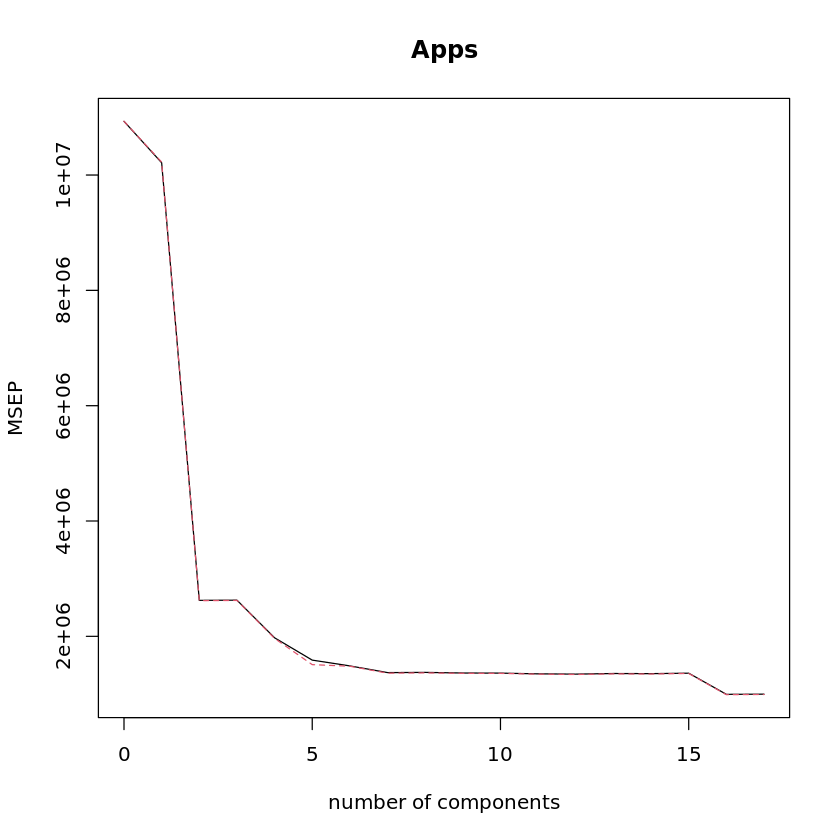

In [109]:
pcr.fit <- pcr(Apps ~ ., data = train,
    scale = TRUE, validation = "CV")
validationplot(pcr.fit, val.type = "MSE") # all of the components are good here; but actually that is just the same as LS?
#So lets go ahead and do 5, 6, or 9?
summary(pcr.fit)


In [128]:
pcr.fit2 <- pcr(Apps ~ ., data = train, ncomp = 10)
pcr.pred2 = predict(pcr.fit2, test, ncomp=10)
mean((pcr.pred2 - test$Apps)^2)

[1] 2053089

(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

Data: 	X dimension: 777 17 
	Y dimension: 777 1
Fit method: kernelpls
Number of components considered: 17

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            3873     1841     1549     1427     1360     1237     1179
adjCV         3873     1839     1548     1423     1344     1211     1169
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV        1176     1165     1164      1162      1160      1162      1160
adjCV     1168     1158     1156      1155      1153      1154      1153
       14 comps  15 comps  16 comps  17 comps
CV         1160      1159      1159      1159
adjCV      1152      1152      1152      1152

TRAINING: % variance explained
      1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X       25.76    40.33    62.59    64.97    66.87    71.33    75.39    79.37
Apps    78.01    85.14    87.67    90.73    92.63    92.72    92.77    

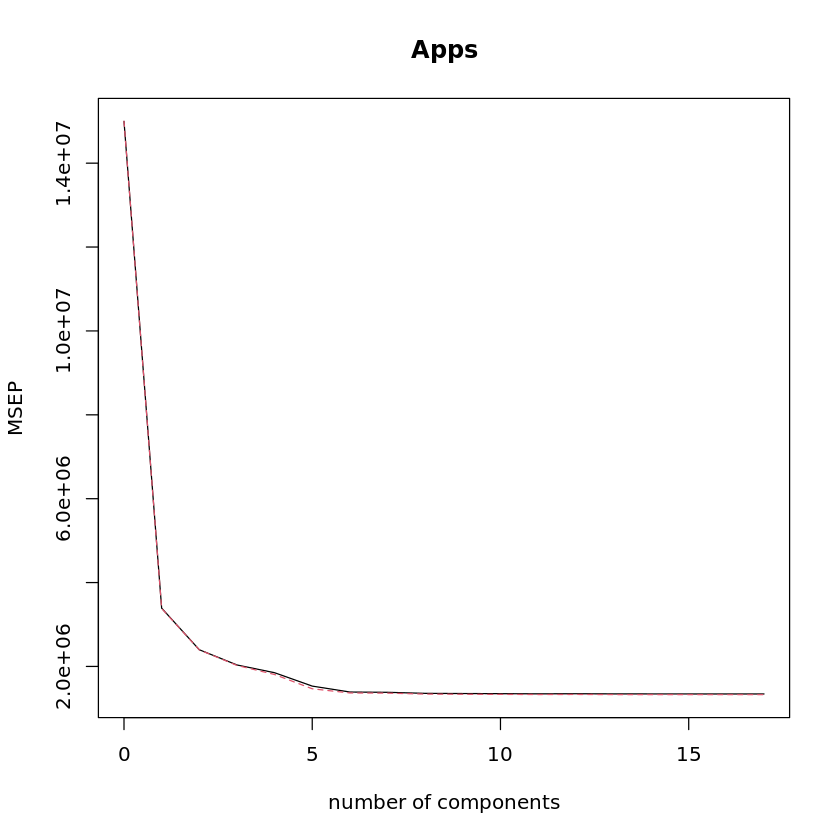

In [123]:
pls.fit <- plsr(Apps ~ ., data = College,
    scale = TRUE, validation = "CV")
validationplot(pls.fit, val.type = "MSEP") # all of the components are good here; but actually that is just the same as LS?
#So lets go ahead and do 5, 6, or 9?
summary(pls.fit)


In [130]:
pls.fit2 <- plsr(Apps ~ ., data = train)
pls.pred2 = predict(pls.fit2, test, ncomp = 10)
mean((pls.pred2 - test$Apps)^2)

[1] 1944200

(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

In [137]:
#Lasso appears to be the best at 1.84E6

#2 variable linear model actually is best at 1.73E6

#Let's go ahead and fit full dataset and get the model

linear_model = lm(Apps ~ Accept + Top10perc, data=College)
summary(linear_model)


Call:
lm(formula = Apps ~ Accept + Top10perc, data = College)

Residuals:
    Min      1Q  Median      3Q     Max 
-5334.2  -513.9   -16.7   325.1  9780.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -892.97561   77.89816  -11.46   <2e-16 ***
Accept         1.44004    0.01678   85.80   <2e-16 ***
Top10perc     35.83112    2.33210   15.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1125 on 774 degrees of freedom
Multiple R-squared:  0.9158,	Adjusted R-squared:  0.9156 
F-statistic:  4208 on 2 and 774 DF,  p-value: < 2.2e-16
